In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.sh_weights = False
args.max_epoch = 1000
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
CPS.set_random_seed(args.seed)
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder='MLP', decoder_latent=[256, 512], distill=1.0, dropout=0.2, flow='source_to_target', freq=8, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2025, self_loops=True, sh_weights=False, sigma=1.0, visual=True, weight_decay=0.0001)

In [4]:
section = '151673'
adata = sc.read_visium(os.path.join(args.dataset_path+section))
Ann_df = pd.read_csv(os.path.join(args.dataset_path+'1-DLPFC_annotations/', section+'_truth.txt'), 
                     sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["counts"] = adata.X.copy()
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=True, max_value=10)

adata_hvg = adata[:, adata.var['highly_variable']].copy()
counts_layer = adata_hvg.layers['counts']

adata.obsm['hvg_features'] = adata_hvg.X
adata.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
spatial_data = CPS.SpatialGraphBuilder(args)
train_data, test_data, train_indices, test_indices = spatial_data.spots_perturb(adata, mask_ratio=0.1, seed=args.seed)
print(train_data)

Data(x=[3276, 2000], edge_index=[2, 26686], y=[3276, 2000], pos=[3276, 2], num_nodes=3276, num_genes=2000)


In [7]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(train_data)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:15.9534, T:7.5874, S:7.5888, D:0.7772]

Epoch  10: Train[Total:9.2304, T:4.2939, S:4.3189, D:0.6176]

Epoch  20: Train[Total:6.3179, T:2.8941, S:2.9554, D:0.4684]

Epoch  30: Train[Total:4.9628, T:2.2162, S:2.2785, D:0.4681]

Epoch  40: Train[Total:4.3571, T:1.9200, S:2.0174, D:0.4197]

Epoch  50: Train[Total:4.2352, T:1.8443, S:1.9558, D:0.4351]

Epoch  60: Train[Total:4.1697, T:1.8043, S:1.9281, D:0.4373]

Epoch  70: Train[Total:4.1126, T:1.7711, S:1.9052, D:0.4362]

Epoch  80: Train[Total:4.0886, T:1.7489, S:1.8936, D:0.4461]

Epoch  90: Train[Total:4.0722, T:1.7313, S:1.8782, D:0.4627]

Epoch 100: Train[Total:4.0554, T:1.7122, S:1.8695, D:0.4736]

Epoch 110: Train[Total:4.0489, T:1.6980, S:1.8605, D:0.4904]

Epoch 120: Train[Total:4.0395, T:1.6825, S:1.8500, D:0.5069]

Epoch 130: Train[Total:4.0428, T:1.6697, S:1.8407, D:0.5323]

Epoch 140: Train[Total:4.0523, T:1.6563, S:1.8408, D:0.5552]

Epoch 150: Train[Total:4.0389, T:1.6449, S:1.8301, D:0.5639]

Epoch 

In [8]:
metrics = cps_model.evaluate_spots_imputation(test_data=test_data, test_indices=test_indices, experiment_name='DLPFC_SI')

进行spots填补，测试spots数量: 363

Spots填补指标 - DLPFC_SI

[基本回归指标]
MSE:           3.976685
RMSE:          1.994163
MAE:           0.682814
R²:            0.724469

[全局相关系数]
Pearson:       0.853009
Spearman:      0.521820

样本数:        726000
指标已保存到: ./results/DLPFC_SI_metrics.json


In [9]:
train_adata = adata[train_indices]
test_adata = adata[test_indices]

In [10]:
train_adata

View of AnnData object with n_obs × n_vars = 3276 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'hvg_features', 'hvg_counts'
    layers: 'counts'

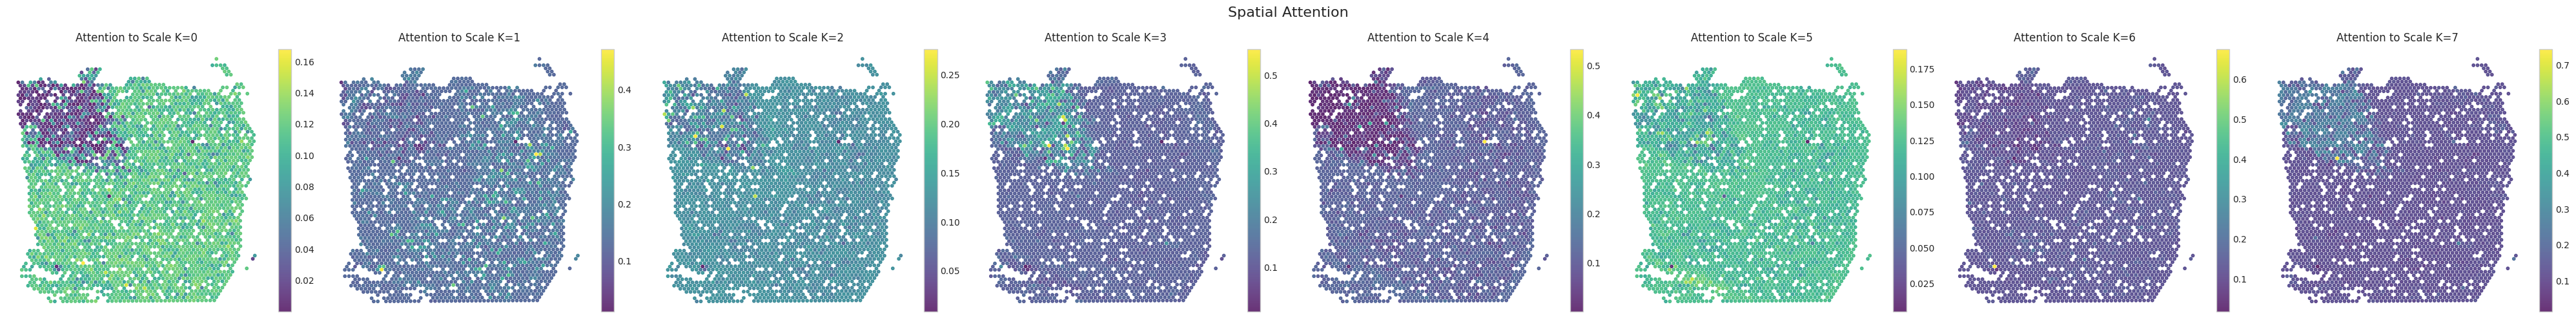

In [11]:
z_s, latent, attn, fig = cps_model.interpret_attn_scores(train_data, return_fig=True)
train_adata.obsm['z_s'] = z_s
train_adata.obsm['z_t'] = latent

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


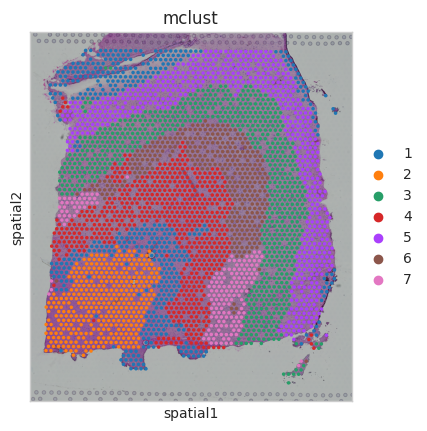

In [12]:
train_adata = CPS.mclust(train_adata, args, key='z_s', pca_dim=32)
sc.pl.spatial(train_adata, img_key="hires", color=["mclust"])

fitting ...
  |======================================================================| 100%


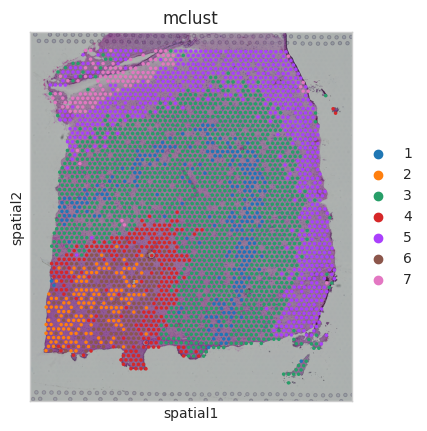

In [13]:
train_adata = CPS.mclust(train_adata, args, key='z_t', pca_dim=32)
sc.pl.spatial(train_adata, img_key="hires", color=["mclust"])